In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pickle



from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks



# change directory go into Notebooks folder
if os.path.basename(os.getcwd()) != 'Notebooks':
    if os.path.basename(os.getcwd()) == 'lib':
        os.chdir(os.path.join(os.getcwd(), '..', 'Notebooks'))
    else:
        os.chdir(os.path.join(os.getcwd(), 'Notebooks'))
else:
    # if already in Notebooks folder, do nothing
    pass

from lib import my_functions as mf

## Loading Data

In [2]:
kmeans_path = '../Output/ica_rest_all/modkmeans_results/'
output_file = os.path.join(kmeans_path,'kmeans_results.npy')
k_means = np.load(output_file, allow_pickle=True).item()

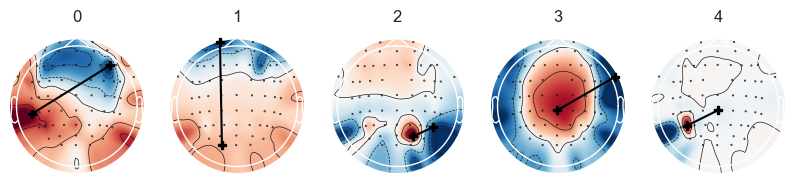

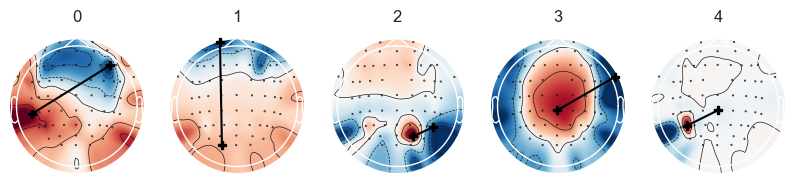

In [3]:
fig, ax = plt.subplots(1,5,figsize=(10, 6))
k_means['kmeans_models'][0].plot(show_gradient=True, show=False, axes=ax)

### Dictionary of microstate setup

In [4]:
import numpy as np
from scipy.stats import pearsonr
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

class MicrostateDictionary:
    """
    Build a global dictionary of unique microstate patterns by incrementally 
    comparing clusters from each subject.
    """
    
    def __init__(self, similarity_threshold=0.8, similarity_metric='correlation'):
        """
        Initialize the microstate dictionary builder.
        
        Parameters:
        -----------
        similarity_threshold : float, default 0.8
            Threshold for considering two clusters as similar enough to merge
        similarity_metric : str, default 'correlation'
            Similarity metric to use ('correlation', 'cosine', 'dot_product')
        """
        self.similarity_threshold = similarity_threshold
        self.similarity_metric = similarity_metric
        
        # Global dictionary of unique patterns
        self.unique_clusters = {}  # {unique_id: cluster_centroid}
        self.cluster_info = {}     # {unique_id: {'subjects': [], 'original_labels': []}}
        
        # Mapping for each subject: {subject_id: {original_label: unique_id}}
        self.subject_mappings = {}
        
        # Counter for assigning unique IDs
        self.next_unique_id = 0
    
    def calculate_similarity(self, cluster1: np.ndarray, cluster2: np.ndarray) -> float:
        """
        Calculate similarity between two cluster centroids using the same metric as ModKMeans.
        
        Parameters:
        -----------
        cluster1, cluster2 : np.ndarray
            Cluster centroids to compare
            
        Returns:
        --------
        float : Similarity score (higher = more similar)
        """
        if self.similarity_metric == 'correlation':
            # Use the SAME metric as pycrostates ModKMeans:
            # "the inverse of the absolute value of the spatial correlation"
            # We return the absolute spatial correlation (higher = more similar)
            corr = np.corrcoef(cluster1.flatten(), cluster2.flatten())[0, 1]
            return abs(corr)  # Absolute spatial correlation
            
        elif self.similarity_metric == 'cosine':
            # Cosine similarity
            dot_product = np.dot(cluster1, cluster2)
            norm1 = np.linalg.norm(cluster1)
            norm2 = np.linalg.norm(cluster2)
            return dot_product / (norm1 * norm2)
            
        elif self.similarity_metric == 'dot_product':
            # Normalized dot product
            cluster1_norm = cluster1 / np.linalg.norm(cluster1)
            cluster2_norm = cluster2 / np.linalg.norm(cluster2)
            return abs(np.dot(cluster1_norm, cluster2_norm))
            
        else:
            raise ValueError(f"Unknown similarity metric: {self.similarity_metric}")
    
    def find_most_similar_cluster(self, new_cluster: np.ndarray) -> Tuple[int, float]:
        """
        Find the most similar existing unique cluster.
        
        Parameters:
        -----------
        new_cluster : np.ndarray
            New cluster centroid to compare
            
        Returns:
        --------
        Tuple of (unique_id, similarity_score) or (-1, 0.0) if none found
        """
        if not self.unique_clusters:
            return -1, 0.0
        
        best_similarity = 0.0
        best_unique_id = -1
        
        for unique_id, existing_cluster in self.unique_clusters.items():
            similarity = self.calculate_similarity(new_cluster, existing_cluster)
            
            if similarity > best_similarity:
                best_similarity = similarity
                best_unique_id = unique_id
        
        return best_unique_id, best_similarity
    
    def add_subject_clusters(self, subject_id: int, cluster_centers: np.ndarray) -> Dict[int, int]:
        """
        Process clusters from one subject and update the global dictionary.
        
        Parameters:
        -----------
        subject_id : int
            Subject identifier
        cluster_centers : np.ndarray
            Cluster centroids for this subject (n_clusters, n_features)
            
        Returns:
        --------
        Dict mapping original cluster labels to unique IDs for this subject
        """
        subject_mapping = {}
        
        for original_label, cluster_centroid in enumerate(cluster_centers):
            # Find most similar existing cluster
            best_unique_id, best_similarity = self.find_most_similar_cluster(cluster_centroid)
            
            if best_similarity >= self.similarity_threshold:
                # Similar enough - assign to existing unique cluster
                unique_id = best_unique_id
                
                # Update cluster info
                self.cluster_info[unique_id]['subjects'].append(subject_id)
                self.cluster_info[unique_id]['original_labels'].append(original_label)
                
                print(f"Subject {subject_id}, Cluster {original_label} -> Unique ID {unique_id} "
                      f"(similarity: {best_similarity:.3f})")
                
            else:
                # Not similar enough - create new unique cluster
                unique_id = self.next_unique_id
                self.unique_clusters[unique_id] = cluster_centroid.copy()
                self.cluster_info[unique_id] = {
                    'subjects': [subject_id],
                    'original_labels': [original_label]
                }
                
                print(f"Subject {subject_id}, Cluster {original_label} -> NEW Unique ID {unique_id}")
                self.next_unique_id += 1
            
            subject_mapping[original_label] = unique_id
        
        self.subject_mappings[subject_id] = subject_mapping
        return subject_mapping
    
    def build_dictionary_from_all_subjects(self, all_centroids: Dict[int, np.ndarray]) -> Dict[int, Dict[int, int]]:
        """
        Build the complete dictionary by processing all subjects sequentially.
        
        Parameters:
        -----------
        all_centroids : Dict
            Dictionary mapping subject_id to cluster_centers array
            
        Returns:
        --------
        Dict : Complete mapping for all subjects {subject_id: {original_label: unique_id}}
        """
        print(f"Building microstate dictionary with threshold={self.similarity_threshold}")
        print(f"Using {self.similarity_metric} similarity metric")
        print("-" * 60)
        
        # Process subjects in order (0 to 49)
        for subject_id in sorted(all_centroids.keys()):
            cluster_centers = all_centroids[subject_id]
            self.add_subject_clusters(subject_id, cluster_centers)
            print()
        
        print(f"Dictionary building complete!")
        print(f"Total unique clusters found: {len(self.unique_clusters)}")
        
        return self.subject_mappings
    
    def build_dictionary_adaptive_threshold(self, all_centroids: Dict[int, np.ndarray], 
                                          target_clusters_per_subject: int = 5,
                                          min_threshold: float = 0.5,
                                          max_threshold: float = 0.99,
                                          step_size: float = 0.05) -> Tuple[Dict[int, Dict[int, int]], float]:
        """
        Build dictionary with adaptive threshold to ensure each subject has exactly 
        target_clusters_per_subject unique clusters while minimizing total unique clusters.
        
        Parameters:
        -----------
        all_centroids : Dict
            Dictionary mapping subject_id to cluster_centers array
        target_clusters_per_subject : int, default 5
            Target number of clusters per subject (excluding -1)
        min_threshold : float, default 0.5
            Minimum similarity threshold to try
        max_threshold : float, default 0.99
            Maximum similarity threshold to try
        step_size : float, default 0.05
            Step size for threshold search
            
        Returns:
        --------
        Tuple[Dict, float] : (Complete mapping for all subjects, final_threshold_used)
        """
        print(f"Building dictionary with adaptive threshold")
        print(f"Target: {target_clusters_per_subject} clusters per subject")
        print(f"Threshold range: {min_threshold} to {max_threshold}")
        print("-" * 60)
        
        best_threshold = None
        best_total_clusters = float('inf')
        best_result = None
        
        # Try different thresholds from high to low
        thresholds_to_try = np.arange(max_threshold, min_threshold - step_size, -step_size)
        
        for threshold in thresholds_to_try:
            print(f"\nTrying threshold: {threshold:.3f}")
            
            # Reset dictionary state
            self.similarity_threshold = threshold
            self.unique_clusters = {}
            self.cluster_info = {}
            self.subject_mappings = {}
            self.next_unique_id = 0
            
            # Build dictionary with current threshold
            temp_mappings = self.build_dictionary_from_all_subjects(all_centroids)
            
            # Check if all subjects have exactly target_clusters_per_subject clusters
            clusters_per_subject = []
            all_subjects_valid = True
            
            for subject_id in sorted(all_centroids.keys()):
                n_unique_clusters = len(set(temp_mappings[subject_id].values()))
                clusters_per_subject.append(n_unique_clusters)
                
                if n_unique_clusters != target_clusters_per_subject:
                    all_subjects_valid = False
            
            total_unique_clusters = len(self.unique_clusters)
            
            print(f"Results: {len([c for c in clusters_per_subject if c == target_clusters_per_subject])}/{len(clusters_per_subject)} subjects have {target_clusters_per_subject} clusters")
            print(f"Total unique clusters: {total_unique_clusters}")
            
            if all_subjects_valid:
                print(f"✓ All subjects have exactly {target_clusters_per_subject} clusters!")
                
                if total_unique_clusters < best_total_clusters:
                    best_threshold = threshold
                    best_total_clusters = total_unique_clusters
                    best_result = {
                        'mappings': temp_mappings.copy(),
                        'unique_clusters': self.unique_clusters.copy(),
                        'cluster_info': self.cluster_info.copy(),
                        'next_unique_id': self.next_unique_id
                    }
                    print(f"✓ New best solution: {total_unique_clusters} total clusters")
            else:
                subjects_with_wrong_count = sum(1 for c in clusters_per_subject if c != target_clusters_per_subject)
                print(f"✗ {subjects_with_wrong_count} subjects don't have {target_clusters_per_subject} clusters")
        
        if best_result is None:
            print(f"\n❌ No threshold found that gives all subjects exactly {target_clusters_per_subject} clusters!")
            print("Suggestions:")
            print(f"  - Try lower min_threshold (current: {min_threshold})")
            print(f"  - Try smaller step_size (current: {step_size})")
            print("  - Your data might have inherent cluster structure that prevents perfect alignment")
            
            # Fall back to regular method with original threshold
            print(f"\nFalling back to regular method with threshold {self.similarity_threshold}")
            fallback_mappings = self.build_dictionary_from_all_subjects(all_centroids)
            return fallback_mappings, self.similarity_threshold
        
        # Restore best solution
        print(f"\n🎯 OPTIMAL SOLUTION FOUND!")
        print(f"Best threshold: {best_threshold:.3f}")
        print(f"Total unique clusters: {best_total_clusters}")
        print(f"All {len(all_centroids)} subjects have exactly {target_clusters_per_subject} clusters")
        
        self.similarity_threshold = best_threshold
        self.subject_mappings = best_result['mappings']
        self.unique_clusters = best_result['unique_clusters']
        self.cluster_info = best_result['cluster_info']
        self.next_unique_id = best_result['next_unique_id']
        
        return self.subject_mappings, best_threshold
    
    def relabel_subject_sequences(self, subject_id: int, original_sequences: np.ndarray) -> np.ndarray:
        """
        Relabel sequences for a specific subject using the mapping.
        
        Parameters:
        -----------
        subject_id : int
            Subject identifier
        original_sequences : np.ndarray
            Original sequences with cluster labels 0-4 and -1 for unclassified
            
        Returns:
        --------
        np.ndarray : Relabeled sequences with unique IDs
        """
        if subject_id not in self.subject_mappings:
            raise ValueError(f"Subject {subject_id} not found in mappings")
        
        mapping = self.subject_mappings[subject_id]
        relabeled = original_sequences.copy()
        
        # Apply mapping (preserve -1 for unclassified)
        for original_label, unique_id in mapping.items():
            relabeled[original_sequences == original_label] = unique_id
        
        return relabeled
    
    def relabel_pycrostates_segmentation(self, subject_id: int, segmentation_obj):
        """
        Relabel sequences directly in a pycrostates EpochsSegmentation object.
        
        Parameters:
        -----------
        subject_id : int
            Subject identifier
        segmentation_obj : EpochsSegmentation
            Pycrostates segmentation object (from ms_ls)
            
        Returns:
        --------
        EpochsSegmentation : New segmentation object with relabeled sequences
        """
        if subject_id not in self.subject_mappings:
            raise ValueError(f"Subject {subject_id} not found in mappings")
        
        # Get original labels (sequences)
        original_labels = segmentation_obj.labels  # This is the array of microstate labels
        
        # Apply relabeling
        relabeled_labels = self.relabel_subject_sequences(subject_id, original_labels)
        
        # Create a copy of the segmentation object with new labels
        # Note: This creates a shallow copy and modifies the labels
        import copy
        new_segmentation = copy.deepcopy(segmentation_obj)
        new_segmentation._labels = relabeled_labels
        
        return new_segmentation
    
    def relabel_all_sequences(self, all_sequences: Dict[int, np.ndarray]) -> Dict[int, np.ndarray]:
        """
        Relabel sequences for all subjects.
        
        Parameters:
        -----------
        all_sequences : Dict
            Dictionary mapping subject_id to sequences array
            
        Returns:
        --------
        Dict : Relabeled sequences for all subjects
        """
        relabeled_sequences = {}
        
        for subject_id, sequences in all_sequences.items():
            relabeled_sequences[subject_id] = self.relabel_subject_sequences(subject_id, sequences)
        
        return relabeled_sequences
    
    def get_cluster_statistics(self) -> Dict:
        """
        Get statistics about the cluster dictionary.
        
        Returns:
        --------
        Dict : Statistics about unique clusters and their usage
        """
        stats = {
            'total_unique_clusters': len(self.unique_clusters),
            'subjects_processed': len(self.subject_mappings),
            'cluster_usage': {}
        }
        
        for unique_id, info in self.cluster_info.items():
            stats['cluster_usage'][unique_id] = {
                'used_by_n_subjects': len(info['subjects']),
                'subjects': info['subjects'],
                'original_labels': info['original_labels']
            }
        
        return stats
    
    def plot_cluster_usage(self, figsize=(12, 8)):
        """
        Visualize cluster usage across subjects.
        """
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot 1: Number of subjects using each unique cluster
        unique_ids = list(self.cluster_info.keys())
        usage_counts = [len(self.cluster_info[uid]['subjects']) for uid in unique_ids]
        
        axes[0, 0].bar(unique_ids, usage_counts)
        axes[0, 0].set_xlabel('Unique Cluster ID')
        axes[0, 0].set_ylabel('Number of Subjects')
        axes[0, 0].set_title('Cluster Usage Across Subjects')
        
        # Plot 2: Distribution of cluster usage
        axes[0, 1].hist(usage_counts, bins=min(10, len(set(usage_counts))), alpha=0.7)
        axes[0, 1].set_xlabel('Number of Subjects Using Cluster')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Distribution of Cluster Usage')
        
        # Plot 3: Subject mapping complexity
        mapping_sizes = [len(mapping) for mapping in self.subject_mappings.values()]
        subject_ids = list(self.subject_mappings.keys())
        
        axes[1, 0].bar(subject_ids, mapping_sizes)
        axes[1, 0].set_xlabel('Subject ID')
        axes[1, 0].set_ylabel('Number of Unique Clusters Mapped')
        axes[1, 0].set_title('Clusters per Subject')
        
        # Plot 4: Unique clusters over time (order of processing)
        cumulative_unique = []
        unique_count = 0
        
        for subject_id in sorted(self.subject_mappings.keys()):
            # Count new unique clusters introduced by this subject
            for original_label, unique_id in self.subject_mappings[subject_id].items():
                if len(self.cluster_info[unique_id]['subjects']) == 1:  # First time this unique_id appears
                    unique_count += 1
            cumulative_unique.append(unique_count)
        
        axes[1, 1].plot(sorted(self.subject_mappings.keys()), cumulative_unique, 'o-')
        axes[1, 1].set_xlabel('Subject ID (Processing Order)')
        axes[1, 1].set_ylabel('Cumulative Unique Clusters')
        axes[1, 1].set_title('Discovery of New Clusters Over Time')
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """
        Print a summary of the dictionary building results.
        """
        stats = self.get_cluster_statistics()
        
        print("\n" + "="*60)
        print("MICROSTATE DICTIONARY SUMMARY")
        print("="*60)
        print(f"Total unique clusters discovered: {stats['total_unique_clusters']}")
        print(f"Subjects processed: {stats['subjects_processed']}")
        print(f"Similarity threshold used: {self.similarity_threshold}")
        print(f"Similarity metric used: {self.similarity_metric}")
        
        print(f"\nCluster usage distribution:")
        usage_counts = [len(info['subjects']) for info in self.cluster_info.values()]
        print(f"  - Most used cluster: used by {max(usage_counts)} subjects")
        print(f"  - Least used cluster: used by {min(usage_counts)} subjects")
        print(f"  - Average usage: {np.mean(usage_counts):.1f} subjects per cluster")
        
        print(f"\nClusters used by only 1 subject: {sum(1 for count in usage_counts if count == 1)}")
        print(f"Clusters used by >50% subjects: {sum(1 for count in usage_counts if count > stats['subjects_processed']/2)}")

# Example usage
if __name__ == "__main__":
    # Initialize dictionary builder
    dictionary = MicrostateDictionary(
        similarity_threshold=0.8,
        similarity_metric='correlation'
    )
    
    # Example: Extract centroids from your kmeans models
    # all_centroids = {}
    # for subject_id in range(50):
    #     all_centroids[subject_id] = k_means['kmeans_models'][subject_id].cluster_centers_
    
    # Build the dictionary
    # mappings = dictionary.build_dictionary_from_all_subjects(all_centroids)
    
    # Relabel your sequences
    # relabeled_sequences = dictionary.relabel_all_sequences(your_sequences_dict)
    
    # Get statistics and visualizations
    # dictionary.print_summary()
    # dictionary.plot_cluster_usage()
    
    print("Microstate dictionary builder ready!")
    print("This approach will:")
    print("1. Process subjects 0-49 in order")
    print("2. Compare each cluster to existing unique patterns") 
    print("3. Assign to existing pattern if similar enough (>threshold)")
    print("4. Create new pattern if too different")
    print("5. Provide mappings to relabel all sequences consistently")

Microstate dictionary builder ready!
This approach will:
1. Process subjects 0-49 in order
2. Compare each cluster to existing unique patterns
3. Assign to existing pattern if similar enough (>threshold)
4. Create new pattern if too different
5. Provide mappings to relabel all sequences consistently


### Relabeling and harmonization of microstates with GFP values

Building microstate dictionary with threshold=0.8
Using correlation similarity metric
------------------------------------------------------------
Subject 0, Cluster 0 -> NEW Unique ID 0
Subject 0, Cluster 1 -> NEW Unique ID 1
Subject 0, Cluster 2 -> NEW Unique ID 2
Subject 0, Cluster 3 -> NEW Unique ID 3
Subject 0, Cluster 4 -> NEW Unique ID 4

Subject 1, Cluster 0 -> Unique ID 3 (similarity: 0.971)
Subject 1, Cluster 1 -> Unique ID 4 (similarity: 0.928)
Subject 1, Cluster 2 -> NEW Unique ID 5
Subject 1, Cluster 3 -> Unique ID 1 (similarity: 0.993)
Subject 1, Cluster 4 -> Unique ID 0 (similarity: 0.960)

Subject 2, Cluster 0 -> NEW Unique ID 6
Subject 2, Cluster 1 -> NEW Unique ID 7
Subject 2, Cluster 2 -> NEW Unique ID 8
Subject 2, Cluster 3 -> Unique ID 6 (similarity: 0.828)
Subject 2, Cluster 4 -> NEW Unique ID 9

Subject 3, Cluster 0 -> NEW Unique ID 10
Subject 3, Cluster 1 -> NEW Unique ID 11
Subject 3, Cluster 2 -> NEW Unique ID 12
Subject 3, Cluster 3 -> NEW Unique ID 13
Subjec

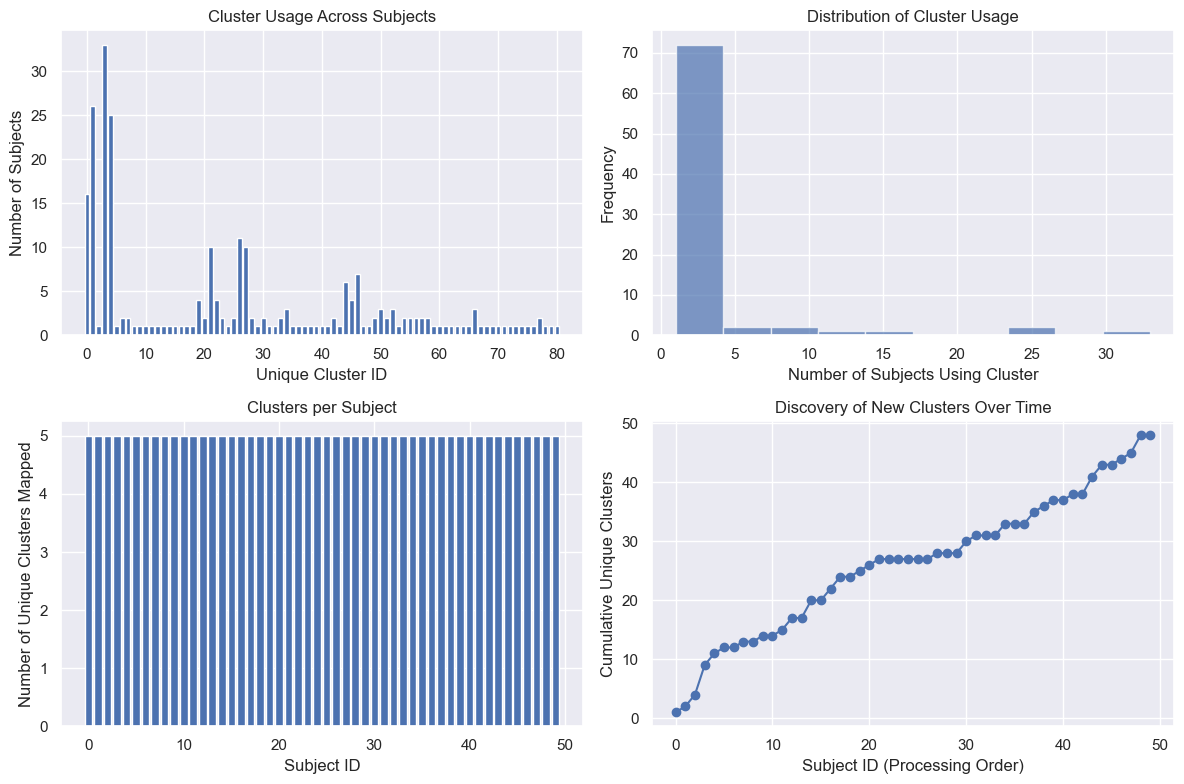

Microstate dictionary builder ready!
This approach will:
1. Process subjects 0-49 in order
2. Compare each cluster to existing unique patterns
3. Assign to existing pattern if similar enough (>threshold)
4. Create new pattern if too different
5. Provide mappings to relabel all sequences consistently


In [5]:

# Initialize dictionary builder
dictionary = MicrostateDictionary(
    similarity_threshold=0.8,
    similarity_metric='correlation'
)

# Example: Extract centroids from your kmeans models
all_centroids = {}
for subject_id in range(50):
    all_centroids[subject_id] = k_means['kmeans_models'][subject_id].cluster_centers_

# Build the dictionary
mappings = dictionary.build_dictionary_from_all_subjects(all_centroids)

# Relabel your sequences
# relabeled_sequences = dictionary.relabel_all_sequences(your_sequences_dict)

# Get statistics and visualizations
dictionary.print_summary()
dictionary.plot_cluster_usage()

print("Microstate dictionary builder ready!")
print("This approach will:")
print("1. Process subjects 0-49 in order")
print("2. Compare each cluster to existing unique patterns") 
print("3. Assign to existing pattern if similar enough (>threshold)")
print("4. Create new pattern if too different")
print("5. Provide mappings to relabel all sequences consistently")

In [6]:
ms_ls = []
kmeans_results_file = os.path.join(kmeans_path, 'kmeans_results.npy')
if not os.path.exists(kmeans_results_file):
    print(f"File {kmeans_results_file} does not exist. Skipping loading microstate sequences.")
kmeans_results = np.load(kmeans_results_file, allow_pickle=True).item()
ms_ls = kmeans_results['microstate_sequence']

In [ ]:
# Initialize dictionary builder
dictionary = MicrostateDictionary(similarity_threshold=0.8)  # Initial threshold (will be adjusted)

# Extract centroids from your kmeans models
all_centroids = {}
for subject_id in range(50):
    all_centroids[subject_id] = k_means['kmeans_models'][subject_id].cluster_centers_

# Build dictionary with adaptive threshold - NOW RETURNS BOTH MAPPINGS AND THRESHOLD
mappings, final_threshold = dictionary.build_dictionary_adaptive_threshold(
    all_centroids, 
    target_clusters_per_subject=5,  # Exactly 5 clusters per subject
    min_threshold=0.8,              # Minimum threshold to try
    max_threshold=0.99,             # Maximum threshold to try  
    step_size=0.01                  # Smaller steps for finer search
)

# Print the final threshold used
print(f"\n🎯 FINAL THRESHOLD USED: {final_threshold:.3f}")

# Extract and relabel sequences
relabeled_sequences = []
for subject_id in range(50):
    original_sequences = ms_ls[subject_id].labels
    relabeled_sequences.append(
        dictionary.relabel_subject_sequences(subject_id, original_sequences)
    )

# Check results
unique_counts = []
for subject_id in range(50):
    unique_labels = np.unique(relabeled_sequences[subject_id])
    unique_counts.append(len(unique_labels[unique_labels != -1]))

print(f"Unique cluster counts per subject: {unique_counts}")
print(f"All subjects have 5 clusters: {all(c == 5 for c in unique_counts)}")
print(f"Total global unique clusters: {len(dictionary.unique_clusters)}", 
      f"(should be <= {5 * 50})")
print(f"Final threshold: {final_threshold:.3f}")



Building dictionary with adaptive threshold
Target: 5 clusters per subject
Threshold range: 0.8 to 0.99
------------------------------------------------------------

Trying threshold: 0.990
Building microstate dictionary with threshold=0.99
Using correlation similarity metric
------------------------------------------------------------
Subject 0, Cluster 0 -> NEW Unique ID 0
Subject 0, Cluster 1 -> NEW Unique ID 1
Subject 0, Cluster 2 -> NEW Unique ID 2
Subject 0, Cluster 3 -> NEW Unique ID 3
Subject 0, Cluster 4 -> NEW Unique ID 4

Subject 1, Cluster 0 -> NEW Unique ID 5
Subject 1, Cluster 1 -> NEW Unique ID 6
Subject 1, Cluster 2 -> NEW Unique ID 7
Subject 1, Cluster 3 -> Unique ID 1 (similarity: 0.993)
Subject 1, Cluster 4 -> NEW Unique ID 8

Subject 2, Cluster 0 -> NEW Unique ID 9
Subject 2, Cluster 1 -> NEW Unique ID 10
Subject 2, Cluster 2 -> NEW Unique ID 11
Subject 2, Cluster 3 -> NEW Unique ID 12
Subject 2, Cluster 4 -> NEW Unique ID 13

Subject 3, Cluster 0 -> NEW Unique ID 1

#### Extracting GFP values and normalizing them, individualy and overall

In [19]:
from sklearn.preprocessing import MinMaxScaler
norm_gfp_indiv = []
for i in range(len(relabeled_sequences)):
    print(f"Microstate sequence for subject {i}: relabeled array shape {relabeled_sequences[i].shape}")
    id_name = f'{i:03d}'  # Format id as three digits
    epochs_path = os.path.join('../output/ica_rest_all', 'epochs/')
    epochs_file = os.path.join(epochs_path, f'epochs_s{id_name}.pkl')
    
    with open(epochs_file, 'rb') as f:
        epochs = pickle.load(f)
    
    gfp_values = np.std(epochs.get_data(), axis=1)  # Compute standard deviation across time for each channel
    gfp_flat = gfp_values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    gfp_normalized_flat = scaler.fit_transform(gfp_flat)
    # Reshape back to original shape
    gfp_values = gfp_normalized_flat.reshape(gfp_values.shape)
    norm_gfp_indiv.append(gfp_values)

Microstate sequence for subject 0: relabeled array shape (400, 1000)
Microstate sequence for subject 1: relabeled array shape (340, 1000)
Microstate sequence for subject 2: relabeled array shape (340, 1000)
Microstate sequence for subject 3: relabeled array shape (340, 1000)
Microstate sequence for subject 4: relabeled array shape (380, 1000)
Microstate sequence for subject 5: relabeled array shape (340, 1000)
Microstate sequence for subject 6: relabeled array shape (400, 1000)
Microstate sequence for subject 7: relabeled array shape (340, 1000)
Microstate sequence for subject 8: relabeled array shape (360, 1000)
Microstate sequence for subject 9: relabeled array shape (360, 1000)
Microstate sequence for subject 10: relabeled array shape (400, 1000)
Microstate sequence for subject 11: relabeled array shape (360, 1000)
Microstate sequence for subject 12: relabeled array shape (380, 1000)
Microstate sequence for subject 13: relabeled array shape (380, 1000)
Microstate sequence for subjec

In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle
import os

# Step 1: Collect all GFP values across all subjects to fit global scaler
all_gfp_values = []

for i in range(len(relabeled_sequences)):
    print(f"Collecting GFP for subject {i}: relabeled array shape {relabeled_sequences[i].shape}")
    id_name = f'{i:03d}'  # Format id as three digits
    epochs_path = os.path.join('../output/ica_rest_all', 'epochs/')
    epochs_file = os.path.join(epochs_path, f'epochs_s{id_name}.pkl')
    
    with open(epochs_file, 'rb') as f:
        epochs = pickle.load(f)
    
    gfp_values = np.std(epochs.get_data(), axis=1)  # Compute standard deviation across time for each channel
    all_gfp_values.append(gfp_values.flatten())

# Fit global scaler on all GFP values
concat_gfp_all = np.concatenate(all_gfp_values, axis=0)
global_scaler = MinMaxScaler(feature_range=(0, 1))
global_scaler.fit(concat_gfp_all.reshape(-1, 1))

print(f"Global GFP range: {concat_gfp_all.min():.6f} to {concat_gfp_all.max():.6f}")

# Step 2: Create globally normalized GFP list
norm_gfp_global = []

for i in range(len(relabeled_sequences)):
    print(f"Normalizing GFP for subject {i}")
    id_name = f'{i:03d}'  # Format id as three digits
    epochs_path = os.path.join('../output/ica_rest_all', 'epochs/')
    epochs_file = os.path.join(epochs_path, f'epochs_s{id_name}.pkl')
    
    with open(epochs_file, 'rb') as f:
        epochs = pickle.load(f)
    
    gfp_values = np.std(epochs.get_data(), axis=1)  # Compute standard deviation across time for each channel
    gfp_flat = gfp_values.reshape(-1, 1)
    gfp_normalized_flat = global_scaler.transform(gfp_flat)  # Use global scaler
    # Reshape back to original shape
    gfp_normalized = gfp_normalized_flat.reshape(gfp_values.shape)
    norm_gfp_global.append(gfp_normalized)
    
    print(f"Subject {i} GFP range after global normalization: {gfp_normalized.min():.6f} to {gfp_normalized.max():.6f}")

print(f"\nCreated norm_gfp_global with {len(norm_gfp_global)} subjects")
print(f"You can now use norm_gfp_global[i] to get globally normalized GFP for subject i")

Global GFP range: 0.604721 to 20223.404461
Normalizing GFP for subject 0
Subject 0 GFP range after global normalization: 0.000021 to 0.003712
Normalizing GFP for subject 1
Subject 1 GFP range after global normalization: 0.000017 to 0.003237
Normalizing GFP for subject 2
Subject 2 GFP range after global normalization: 0.000017 to 0.096002
Normalizing GFP for subject 3
Subject 3 GFP range after global normalization: 0.000022 to 0.008792
Normalizing GFP for subject 4
Subject 4 GFP range after global normalization: 0.000049 to 0.007919
Normalizing GFP for subject 5
Subject 5 GFP range after global normalization: 0.000013 to 0.008352
Normalizing GFP for subject 6
Subject 6 GFP range after global normalization: 0.000003 to 0.001141
Normalizing GFP for subject 7
Subject 7 GFP range after global normalization: 0.000010 to 0.004522
Normalizing GFP for subject 8
Subject 8 GFP range after global normalization: 0.000014 to 0.007064
Normalizing GFP for subject 9
Subject 9 GFP range after global nor

In [39]:
from sklearn.preprocessing import MinMaxScaler
ms_gfp_ls_indiv_harm = []
ms_gfp_ls_overall_harm = []
for i, gfp_values_indiv, gfp_values_overall in zip(range(len(relabeled_sequences)), norm_gfp_indiv, norm_gfp_global):
    # Use relabeled_sequences instead of ms.labels
    relabeled_labels = relabeled_sequences[i]  # This is your numpy array with shape (n_epochs, n_timepoints)
    
    df_ms_indiv = []
    df_ms_overall = []
    for j in range(len(relabeled_labels)):  # Iterate through epochs
        # Stack the relabeled microstate sequence with GFP for each epoch
        df_ms_indiv.append(np.stack([relabeled_labels[j], gfp_values_indiv[j]], axis=0))
        df_ms_overall.append(np.stack([relabeled_labels[j], gfp_values_overall[j]], axis=0))
    ms_gfp_ls_indiv_harm.append(df_ms_indiv)
    ms_gfp_ls_overall_harm.append(df_ms_overall)

# Save the final mappings and unique clusters
ms_gfp_indiv_file = os.path.join(kmeans_path, 'modkmeans_sequence_harmonize_indiv.pkl')
with open(ms_gfp_indiv_file, 'wb') as f:
    pickle.dump(ms_gfp_ls_indiv_harm, f)
print(f"Relabeled sequences with individual normalization saved to {ms_gfp_indiv_file}")
ms_gfp_overall_file = os.path.join(kmeans_path, 'modkmeans_sequence_harmonize_overall.pkl')
with open(ms_gfp_overall_file, 'wb') as f:
    pickle.dump(ms_gfp_ls_overall_harm, f)
print(f"Relabeled sequences with overall normalization saved to {ms_gfp_overall_file}")

Relabeled sequences with individual normalization saved to ../Output/ica_rest_all/modkmeans_results/modkmeans_sequence_harmonize_indiv.pkl
Relabeled sequences with overall normalization saved to ../Output/ica_rest_all/modkmeans_results/modkmeans_sequence_harmonize_overall.pkl


In [40]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_w_gfp(ms_gfp_ls):
    finals_ls = []
    for i, ms in enumerate(ms_gfp_ls):
        # ms is a list of microstate sequences for subject i
        # Convert to numpy array for easier manipulation
        data = np.array(ms)  # shape: (n_trials, 2, timepoints)
        
        # Step 1: Extract categorical values (row 0 = labels)
        labels = data[:, 0, :]  # shape: (n_trials, timepoints)
        
        # Step 2: Extract GFP values (row 1 = GFP)
        gfp_values = data[:, [1], :]  # shape: (n_trials, 1, timepoints)

        
        # Step 3: Flatten labels for one-hot encoding
        flat_labels = labels.reshape(-1, 1)
        
        # Step 4: One-hot encode
        encoder = OneHotEncoder(sparse_output=False)
        one_hot = encoder.fit_transform(flat_labels)  # shape: (n_trials * timepoints, n_classes)
        
        # Step 5: Reshape back
        n_trials, timepoints = labels.shape
        n_classes = one_hot.shape[1]
        one_hot_reshaped = one_hot.reshape(n_trials, timepoints, n_classes).transpose(0, 2, 1)  # (n_trials, n_classes, timepoints)
        
        # Step 6: Concatenate normalized GFP with one-hot encoded labels
        final = np.concatenate([one_hot_reshaped, gfp_values], axis=1)  # (n_trials, n_classes + 1, timepoints)
        finals_ls.append(final)

    return finals_ls

#### Dependent

In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

finals_ls = one_hot_w_gfp(ms_gfp_ls_indiv_harm)

# Check the structure
print(f"Final shape for subject 0: {finals_ls[0].shape}")
print(f"GFP channel (normalized): {finals_ls[0][:, -1, :5]}  # First 5 timepoints")
print(f"GFP min/max for subject 0: {finals_ls[0][:, -1, :].min():.3f}/{finals_ls[0][:, -1, :].max():.3f}")
print(f"One-hot channels: {finals_ls[0][:, :-1, :5].shape}  # Shape of one-hot part")

# Save the final mappings and unique clusters
output_path = '../Output/ica_rest_all/'
output_file = os.path.join(output_path, 'ms_timeseries_harmonize.pkl')
with open(output_file, 'wb') as f:
    pickle.dump(finals_ls, f)
print(f"Relabeled sequences saved to {output_file}")

Final shape for subject 0: (400, 7, 1000)
GFP channel (normalized): [[0.0342549  0.04055409 0.06178215 0.06521511 0.06083297]
 [0.02709604 0.04163712 0.06000453 0.0688425  0.07514013]
 [0.0050698  0.01240369 0.02574825 0.03159033 0.03073642]
 ...
 [0.02735245 0.02663507 0.04605557 0.04865945 0.04084722]
 [0.02537794 0.0319623  0.04099518 0.04553133 0.05306088]
 [0.00969641 0.02056858 0.04035088 0.05666261 0.06929863]]  # First 5 timepoints
GFP min/max for subject 0: 0.000/1.000
One-hot channels: (400, 6, 5)  # Shape of one-hot part
Relabeled sequences saved to ../Output/ica_rest_all/ms_timeseries_harmonize.pkl


#### Independent

In [42]:

# Step 2: Process each subject with the global scaler
finals_ls = one_hot_w_gfp(ms_gfp_ls_overall_harm)

# Check the structure
print(f"Final shape for subject 0: {finals_ls[0].shape}")
print(f"GFP channel (normalized): {finals_ls[0][:, -1, :5]}  # First 5 timepoints")
print(f"Global GFP min/max: {scaler.data_min_[0]:.3f}/{scaler.data_max_[0]:.3f}")
print(f"Subject 0 GFP min/max: {finals_ls[0][:, -1, :].min():.3f}/{finals_ls[0][:, -1, :].max():.3f}")
print(f"One-hot channels: {finals_ls[0][:, :-1, :5].shape}  # Shape of one-hot part")

# Save the final mappings and unique clusters
output_path = '../Output/ica_rest_all/'
output_file = os.path.join(output_path, 'ms_timeseries_harmonize_overall.pkl')
with open(output_file, 'wb') as f:
    pickle.dump(finals_ls, f)
print(f"Relabeled sequences saved to {output_file}")

Final shape for subject 0: (400, 7, 1000)
GFP channel (normalized): [[1.47912198e-04 1.71159577e-04 2.49502488e-04 2.62171941e-04
  2.45999490e-04]
 [1.21492166e-04 1.75156520e-04 2.42942109e-04 2.75558953e-04
  2.98800597e-04]
 [4.02035367e-05 6.72695013e-05 1.16518087e-04 1.38078509e-04
  1.34927096e-04]
 ...
 [1.22438443e-04 1.19790929e-04 1.91462982e-04 2.01072679e-04
  1.72241396e-04]
 [1.15151440e-04 1.39451252e-04 1.72787424e-04 1.89528261e-04
  2.17316331e-04]
 [5.72781981e-05 9.74023240e-05 1.70409639e-04 2.30608629e-04
  2.77242314e-04]]  # First 5 timepoints
Global GFP min/max: 0.605/55.289
Subject 0 GFP min/max: 0.000/0.004
One-hot channels: (400, 6, 5)  # Shape of one-hot part
Relabeled sequences saved to ../Output/ica_rest_all/ms_timeseries_harmonize_overall.pkl


### Regular microstates 1 hot encoding of labels

In [43]:
ms_ls = k_means['microstate_sequence']

ms_gfp_ls_indiv = []
ms_gfp_ls_overall = []
for i, gfp_values_indiv, gfp_values_overall in zip(range(len(ms_ls)), norm_gfp_indiv, norm_gfp_global):
    # Use relabeled_sequences instead of ms.labels
    labels = ms_ls[i].labels  # This is your numpy array with shape (n_epochs, n_timepoints)
    
    df_ms_indiv = []
    df_ms_overall = []
    for j in range(len(labels)):  # Iterate through epochs
        # Stack the relabeled microstate sequence with GFP for each epoch
        df_ms_indiv.append(np.stack([labels[j], gfp_values_indiv[j]], axis=0))
        df_ms_overall.append(np.stack([labels[j], gfp_values_overall[j]], axis=0))
    ms_gfp_ls_indiv.append(df_ms_indiv)
    ms_gfp_ls_overall.append(df_ms_overall)

# Save the final mappings and unique clusters
ms_gfp_indiv_file = os.path.join(kmeans_path, 'modkmeans_sequence_indiv.pkl')
with open(ms_gfp_indiv_file, 'wb') as f:
    pickle.dump(ms_gfp_ls_indiv, f)
print(f"Relabeled sequences with individual normalization saved to {ms_gfp_indiv_file}")
ms_gfp_overall_file = os.path.join(kmeans_path, 'modkmeans_sequence_overall.pkl')
with open(ms_gfp_overall_file, 'wb') as f:
    pickle.dump(ms_gfp_ls_overall, f)
print(f"Relabeled sequences with overall normalization saved to {ms_gfp_overall_file}")


Relabeled sequences with individual normalization saved to ../Output/ica_rest_all/modkmeans_results/modkmeans_sequence_indiv.pkl
Relabeled sequences with overall normalization saved to ../Output/ica_rest_all/modkmeans_results/modkmeans_sequence_overall.pkl


#### Dependent

In [44]:
finals_ls = one_hot_w_gfp(ms_gfp_ls_indiv)
ms_timeseries_path = os.path.join(output_path, 'ms_timeseries.pkl')
with open(ms_timeseries_path, 'wb') as f:
    # Save the list of numpy arrays
    pickle.dump(finals_ls, f)

#### Independent

In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Step 2: Process each subject with the global scaler
finals_ls = one_hot_w_gfp(ms_gfp_ls_overall)

# Check the structure
print(f"Final shape for subject 0: {finals_ls[0].shape}")
print(f"GFP channel (normalized): {finals_ls[0][:, -1, :5]}  # First 5 timepoints")
print(f"Global GFP min/max: {scaler.data_min_[0]:.3f}/{scaler.data_max_[0]:.3f}")
print(f"Subject 0 GFP min/max: {finals_ls[0][:, -1, :].min():.3f}/{finals_ls[0][:, -1, :].max():.3f}")
print(f"One-hot channels: {finals_ls[0][:, :-1, :5].shape}  # Shape of one-hot part")
print()

# Save the final mappings and unique clusters
output_path = '../Output/ica_rest_all/'
output_file = os.path.join(output_path, 'ms_timeseries_overall.pkl')
with open(output_file, 'wb') as f:
    pickle.dump(finals_ls, f)
print(f"Relabeled sequences saved to {output_file}")

Final shape for subject 0: (400, 7, 1000)
GFP channel (normalized): [[1.47912198e-04 1.71159577e-04 2.49502488e-04 2.62171941e-04
  2.45999490e-04]
 [1.21492166e-04 1.75156520e-04 2.42942109e-04 2.75558953e-04
  2.98800597e-04]
 [4.02035367e-05 6.72695013e-05 1.16518087e-04 1.38078509e-04
  1.34927096e-04]
 ...
 [1.22438443e-04 1.19790929e-04 1.91462982e-04 2.01072679e-04
  1.72241396e-04]
 [1.15151440e-04 1.39451252e-04 1.72787424e-04 1.89528261e-04
  2.17316331e-04]
 [5.72781981e-05 9.74023240e-05 1.70409639e-04 2.30608629e-04
  2.77242314e-04]]  # First 5 timepoints
Global GFP min/max: 0.605/55.289
Subject 0 GFP min/max: 0.000/0.004
One-hot channels: (400, 6, 5)  # Shape of one-hot part

Relabeled sequences saved to ../Output/ica_rest_all/ms_timeseries_overall.pkl
